In [1]:
import os, time
from datetime import datetime
file_mtime = datetime.fromtimestamp((os.path.getmtime("README.ipynb"))).strftime("%d/%m/%Y %H:%M:%S")
comp_time = datetime.now().strftime("%d/%m/%Y %H:%M:%S")

%matplotlib inline

# Breaking Text-Based CAPTCHA with Convolutional Nerual Network (CNN)
**Author**: Xiurui Zhu<br />
**Modified**: {{file_mtime}}<br />
**Compiled**: {{comp_time}}

## Data preparation

Image files were loaded from the `png` files in `samples` directory.

In [2]:
import glob
img_filenames = [f for f in glob.glob("samples/*.png")]
img_filenames_count = len(img_filenames)

import numpy as np
from matplotlib import pyplot
data_x = np.array(list(map(lambda x: pyplot.imread(x, format = "PNG"), img_filenames)))

A total of {{img_filenames_count}} images were loaded. An example image was as follows:

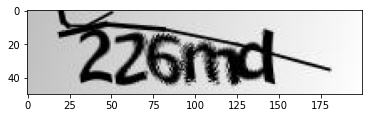

In [3]:
pyplot.imshow(data_x[0]);

The labels were then loaded from the file names and turned them into a list of categorical matrices with one digit per element.

In [4]:
# Define the number of digits and letters per CAPTCHA
import string
digit = 5
class_level = [*string.ascii_lowercase, *string.digits]

# Define a function to convert character vector to categorical matrix list
from tensorflow import keras
def labels2matrices(labels, class_level):
    char_ind_array = np.array([[class_level.index(char) for char in label] for label in labels])
    return list(map(lambda char_ind: keras.utils.to_categorical(char_ind, num_classes = len(class_level), dtype = 'float32'),
                    np.ndarray.tolist(np.transpose(char_ind_array))))

# Process image labels
data_y_labels = [os.path.splitext(os.path.basename(img_filename))[0] for img_filename in img_filenames]
data_y = labels2matrices(data_y_labels, class_level)
print(len(data_y))
print(np.shape(data_y[0]))

5
(1040, 36)


## Modeling

A CNN model was built to break the text-based CAPTCHA. A CNN model consists of two parts, one as convolutional model and the other as deep neural-network (DNN) model, joined by a flatten layer. Since there are multiple digits to predict for each CAPTCHA image, we would build the model including a common convolutional model, a common flatten layer and multiple DNN models (one for each digit).

### Convolutional model

The convolutional model (diagram as below) was built by adding multiple modules of convolutional and max-pooling layers, optionally adding a batch-normalization layer to improve model convergence.

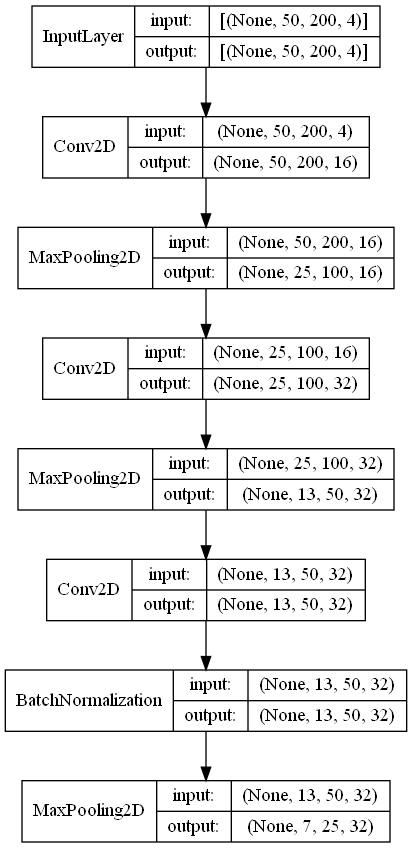

In [12]:
import tensorflow
from tensorflow import keras
from tensorflow.keras import layers
tensorflow.random.set_seed(599)

# Define the convolutional model
input_layer = keras.Input(shape = np.shape(data_x)[1:])
conv_layer = layers.Conv2D(16, kernel_size = (3, 3), padding = "same", activation = "relu")(input_layer)
conv_layer = layers.MaxPooling2D(pool_size = (2, 2), padding = "same")(conv_layer)
conv_layer = layers.Conv2D(32, kernel_size = (3, 3), padding = "same", activation = "relu")(conv_layer)
conv_layer = layers.MaxPooling2D(pool_size = (2, 2), padding = "same")(conv_layer)
conv_layer = layers.Conv2D(32, kernel_size = (3, 3), padding = "same", activation = "relu")(conv_layer)
conv_layer = layers.BatchNormalization()(conv_layer)
conv_layer = layers.MaxPooling2D(pool_size = (2, 2), padding = "same")(conv_layer)
conv_layer_flatten = layers.Flatten()(conv_layer)

conv_model = keras.Model(inputs = input_layer, outputs = conv_layer)

keras.utils.plot_model(conv_model, to_file = "conv_model.png", show_shapes = True, show_layer_names = False)

### Deep neural network (DNN) models

Each DNN model (diagram as below) was built with a hidden layer and a dropout layer, with the latter as a regularization method to prevent overfitting. The output layer of each DNN model adopted a multi-class configuration with the unit as the number of possibilities per digit and activation function as "softmax". The input layer of each DNN model was copied from the shape of the output from the flatten layer.

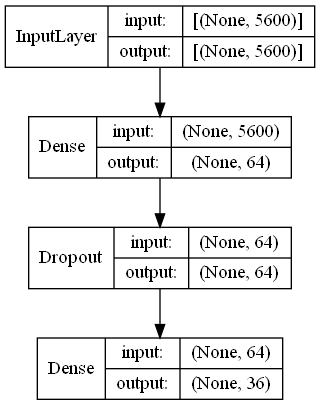

In [13]:
# Define a function that copies the shape of a layer and defines an input layer
def build_deep_layer(input_layer, class_level):
    deep_layer = layers.Dense(64, activation = "relu")(input_layer)
    deep_layer = layers.Dropout(0.5)(deep_layer)
    deep_layer = layers.Dense(len(class_level), activation = "softmax")(deep_layer)
    return deep_layer

deep_layers = [
    build_deep_layer(conv_layer_flatten, class_level) for _ in range(digit)
]

deep_models = [keras.Model(inputs = conv_layer_flatten, outputs = deep_layer) for deep_layer in deep_layers]

keras.utils.plot_model(deep_models[0], to_file = "deep_model.png", show_shapes = True, show_layer_names = False)

### Assembled CNN model

The convolutional model and the DNN models were assembled into a final CNN model (diagram as below) and the final CNN model was compiled for training.

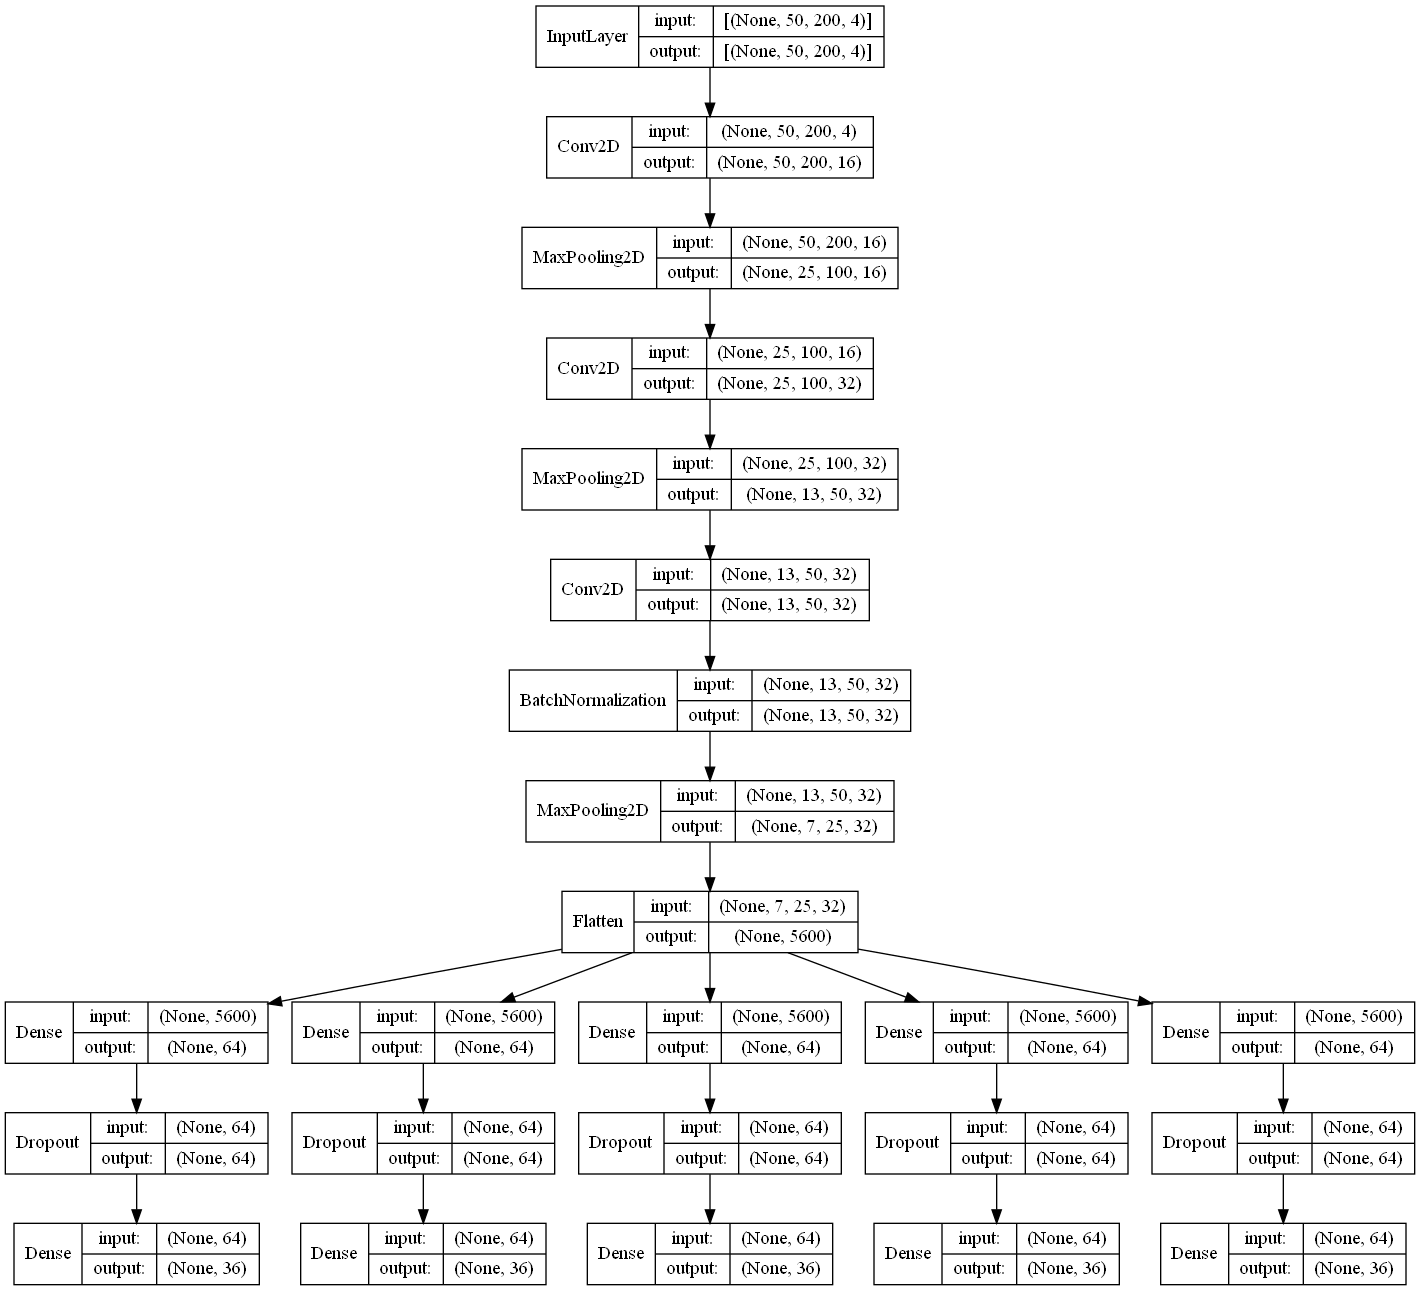

In [14]:
model = keras.Model(
    inputs = input_layer,
    outputs = deep_layers
)

keras.utils.plot_model(model, to_file = "final_model.png", show_shapes = True, show_layer_names = False)

In [86]:
n_train = 940
n_test = img_filenames_count - n_train
cv_frac = 0.2
cv_frac_perc = str(cv_frac * 100) + "%"

## Results

### Model training

The final CNN model was trained with {{n_train}} images with {{cv_frac_perc}} of them as cross-validation dataset.

In [15]:
from numpy import random
random.seed(999)
train_idx = random.choice(range(img_filenames_count), size = n_train, replace = False, p = None)

data_y_train = [data_y_digit[train_idx] for data_y_digit in data_y]

# Compile the final model
model.compile(loss = "categorical_crossentropy", optimizer = "adam", metrics = ["accuracy"])
# Train model
model_history = model.fit(data_x[train_idx], data_y_train, batch_size = 32, epochs = 200, validation_split = cv_frac)
model.save("final_model")

Epoch 1/200
24/24 [==============================] - 6s 188ms/step - loss: 18.9387 - dense_11_loss: 3.7356 - dense_13_loss: 3.7454 - dense_15_loss: 3.8446 - dense_17_loss: 3.8339 - dense_19_loss: 3.7792 - dense_11_accuracy: 0.0465 - dense_13_accuracy: 0.0731 - dense_15_accuracy: 0.0465 - dense_17_accuracy: 0.0479 - dense_19_accuracy: 0.0678 - val_loss: 43.2619 - val_dense_11_loss: 10.1897 - val_dense_13_loss: 7.1901 - val_dense_15_loss: 7.7431 - val_dense_17_loss: 6.0145 - val_dense_19_loss: 12.1245 - val_dense_11_accuracy: 0.0372 - val_dense_13_accuracy: 0.0479 - val_dense_15_accuracy: 0.0000e+00 - val_dense_17_accuracy: 0.0426 - val_dense_19_accuracy: 0.0372
Epoch 2/200
24/24 [==============================] - 4s 161ms/step - loss: 17.5690 - dense_11_loss: 3.4885 - dense_13_loss: 3.5591 - dense_15_loss: 3.5605 - dense_17_loss: 3.4381 - dense_19_loss: 3.5227 - dense_11_accuracy: 0.0705 - dense_13_accuracy: 0.0944 - dense_15_accuracy: 0.0997 - dense_17_accuracy: 0.0598 - dense_19_accur

24/24 [==============================] - 4s 172ms/step - loss: 14.9491 - dense_11_loss: 2.4894 - dense_13_loss: 3.4181 - dense_15_loss: 3.1117 - dense_17_loss: 2.8023 - dense_19_loss: 3.1275 - dense_11_accuracy: 0.2101 - dense_13_accuracy: 0.0878 - dense_15_accuracy: 0.1170 - dense_17_accuracy: 0.1197 - dense_19_accuracy: 0.1157 - val_loss: 14.2643 - val_dense_11_loss: 2.3133 - val_dense_13_loss: 3.3993 - val_dense_15_loss: 3.0099 - val_dense_17_loss: 2.5693 - val_dense_19_loss: 2.9724 - val_dense_11_accuracy: 0.4415 - val_dense_13_accuracy: 0.0904 - val_dense_15_accuracy: 0.1064 - val_dense_17_accuracy: 0.2234 - val_dense_19_accuracy: 0.1223
Epoch 14/200
24/24 [==============================] - 4s 171ms/step - loss: 14.6892 - dense_11_loss: 2.4030 - dense_13_loss: 3.3909 - dense_15_loss: 2.9855 - dense_17_loss: 2.7661 - dense_19_loss: 3.1436 - dense_11_accuracy: 0.1902 - dense_13_accuracy: 0.0918 - dense_15_accuracy: 0.1383 - dense_17_accuracy: 0.1396 - dense_19_accuracy: 0.1117 - val

24/24 [==============================] - 4s 176ms/step - loss: 12.1241 - dense_11_loss: 1.3941 - dense_13_loss: 2.9895 - dense_15_loss: 2.5821 - dense_17_loss: 2.4467 - dense_19_loss: 2.7117 - dense_11_accuracy: 0.4907 - dense_13_accuracy: 0.1197 - dense_15_accuracy: 0.1582 - dense_17_accuracy: 0.1795 - dense_19_accuracy: 0.1556 - val_loss: 10.7463 - val_dense_11_loss: 0.9774 - val_dense_13_loss: 2.9784 - val_dense_15_loss: 2.2741 - val_dense_17_loss: 2.2281 - val_dense_19_loss: 2.2883 - val_dense_11_accuracy: 0.7287 - val_dense_13_accuracy: 0.1330 - val_dense_15_accuracy: 0.2926 - val_dense_17_accuracy: 0.3511 - val_dense_19_accuracy: 0.2234
Epoch 26/200
24/24 [==============================] - 5s 201ms/step - loss: 11.7518 - dense_11_loss: 1.3602 - dense_13_loss: 2.9599 - dense_15_loss: 2.4294 - dense_17_loss: 2.4007 - dense_19_loss: 2.6017 - dense_11_accuracy: 0.5226 - dense_13_accuracy: 0.1423 - dense_15_accuracy: 0.2194 - dense_17_accuracy: 0.1875 - dense_19_accuracy: 0.1809 - val

24/24 [==============================] - 4s 178ms/step - loss: 8.0114 - dense_11_loss: 0.7720 - dense_13_loss: 1.7395 - dense_15_loss: 1.5810 - dense_17_loss: 2.1172 - dense_19_loss: 1.8019 - dense_11_accuracy: 0.7261 - dense_13_accuracy: 0.4255 - dense_15_accuracy: 0.4495 - dense_17_accuracy: 0.2580 - dense_19_accuracy: 0.3537 - val_loss: 5.5742 - val_dense_11_loss: 0.2343 - val_dense_13_loss: 1.1799 - val_dense_15_loss: 1.0055 - val_dense_17_loss: 1.8310 - val_dense_19_loss: 1.3235 - val_dense_11_accuracy: 0.9362 - val_dense_13_accuracy: 0.6436 - val_dense_15_accuracy: 0.7394 - val_dense_17_accuracy: 0.4521 - val_dense_19_accuracy: 0.5479
Epoch 38/200
24/24 [==============================] - 4s 168ms/step - loss: 7.7167 - dense_11_loss: 0.7125 - dense_13_loss: 1.6693 - dense_15_loss: 1.4466 - dense_17_loss: 2.0906 - dense_19_loss: 1.7977 - dense_11_accuracy: 0.7500 - dense_13_accuracy: 0.4601 - dense_15_accuracy: 0.4880 - dense_17_accuracy: 0.2633 - dense_19_accuracy: 0.3856 - val_lo

24/24 [==============================] - 4s 170ms/step - loss: 5.0401 - dense_11_loss: 0.4048 - dense_13_loss: 0.9160 - dense_15_loss: 0.8955 - dense_17_loss: 1.6581 - dense_19_loss: 1.1657 - dense_11_accuracy: 0.8391 - dense_13_accuracy: 0.6848 - dense_15_accuracy: 0.6476 - dense_17_accuracy: 0.4282 - dense_19_accuracy: 0.5678 - val_loss: 2.9776 - val_dense_11_loss: 0.0907 - val_dense_13_loss: 0.4277 - val_dense_15_loss: 0.4036 - val_dense_17_loss: 1.3921 - val_dense_19_loss: 0.6635 - val_dense_11_accuracy: 0.9787 - val_dense_13_accuracy: 0.9255 - val_dense_15_accuracy: 0.8723 - val_dense_17_accuracy: 0.5638 - val_dense_19_accuracy: 0.7660
Epoch 50/200
24/24 [==============================] - 4s 169ms/step - loss: 4.9425 - dense_11_loss: 0.3949 - dense_13_loss: 0.9102 - dense_15_loss: 0.8304 - dense_17_loss: 1.7268 - dense_19_loss: 1.0800 - dense_11_accuracy: 0.8378 - dense_13_accuracy: 0.6795 - dense_15_accuracy: 0.6822 - dense_17_accuracy: 0.3923 - dense_19_accuracy: 0.5864 - val_lo

24/24 [==============================] - 4s 175ms/step - loss: 3.6736 - dense_11_loss: 0.2681 - dense_13_loss: 0.6664 - dense_15_loss: 0.5810 - dense_17_loss: 1.2329 - dense_19_loss: 0.9253 - dense_11_accuracy: 0.9096 - dense_13_accuracy: 0.7606 - dense_15_accuracy: 0.7872 - dense_17_accuracy: 0.5559 - dense_19_accuracy: 0.6383 - val_loss: 2.2602 - val_dense_11_loss: 0.0914 - val_dense_13_loss: 0.2951 - val_dense_15_loss: 0.3639 - val_dense_17_loss: 0.9563 - val_dense_19_loss: 0.5536 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9521 - val_dense_15_accuracy: 0.8883 - val_dense_17_accuracy: 0.7234 - val_dense_19_accuracy: 0.7819
Epoch 62/200
24/24 [==============================] - 4s 171ms/step - loss: 3.5946 - dense_11_loss: 0.2510 - dense_13_loss: 0.6394 - dense_15_loss: 0.5845 - dense_17_loss: 1.1939 - dense_19_loss: 0.9259 - dense_11_accuracy: 0.9109 - dense_13_accuracy: 0.7660 - dense_15_accuracy: 0.7832 - dense_17_accuracy: 0.5705 - dense_19_accuracy: 0.6636 - val_lo

24/24 [==============================] - 5s 199ms/step - loss: 2.6664 - dense_11_loss: 0.1703 - dense_13_loss: 0.4956 - dense_15_loss: 0.4468 - dense_17_loss: 0.8542 - dense_19_loss: 0.6996 - dense_11_accuracy: 0.9348 - dense_13_accuracy: 0.8191 - dense_15_accuracy: 0.8298 - dense_17_accuracy: 0.6755 - dense_19_accuracy: 0.7500 - val_loss: 2.0258 - val_dense_11_loss: 0.0833 - val_dense_13_loss: 0.2681 - val_dense_15_loss: 0.3217 - val_dense_17_loss: 0.9093 - val_dense_19_loss: 0.4435 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9468 - val_dense_15_accuracy: 0.9149 - val_dense_17_accuracy: 0.7713 - val_dense_19_accuracy: 0.8777
Epoch 74/200
24/24 [==============================] - 5s 197ms/step - loss: 2.6262 - dense_11_loss: 0.1721 - dense_13_loss: 0.5223 - dense_15_loss: 0.4156 - dense_17_loss: 0.8187 - dense_19_loss: 0.6976 - dense_11_accuracy: 0.9388 - dense_13_accuracy: 0.8019 - dense_15_accuracy: 0.8378 - dense_17_accuracy: 0.6888 - dense_19_accuracy: 0.7354 - val_lo

24/24 [==============================] - 4s 183ms/step - loss: 2.2707 - dense_11_loss: 0.1781 - dense_13_loss: 0.4312 - dense_15_loss: 0.3980 - dense_17_loss: 0.6998 - dense_19_loss: 0.5636 - dense_11_accuracy: 0.9375 - dense_13_accuracy: 0.8418 - dense_15_accuracy: 0.8364 - dense_17_accuracy: 0.7274 - dense_19_accuracy: 0.8005 - val_loss: 2.3708 - val_dense_11_loss: 0.0741 - val_dense_13_loss: 0.3237 - val_dense_15_loss: 0.3951 - val_dense_17_loss: 0.9880 - val_dense_19_loss: 0.5899 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9468 - val_dense_15_accuracy: 0.9255 - val_dense_17_accuracy: 0.7447 - val_dense_19_accuracy: 0.8511
Epoch 86/200
24/24 [==============================] - 5s 191ms/step - loss: 2.2160 - dense_11_loss: 0.1764 - dense_13_loss: 0.3987 - dense_15_loss: 0.3475 - dense_17_loss: 0.7504 - dense_19_loss: 0.5430 - dense_11_accuracy: 0.9455 - dense_13_accuracy: 0.8577 - dense_15_accuracy: 0.8723 - dense_17_accuracy: 0.7340 - dense_19_accuracy: 0.8098 - val_lo

24/24 [==============================] - 4s 178ms/step - loss: 1.8837 - dense_11_loss: 0.1012 - dense_13_loss: 0.3537 - dense_15_loss: 0.2912 - dense_17_loss: 0.6433 - dense_19_loss: 0.4943 - dense_11_accuracy: 0.9574 - dense_13_accuracy: 0.8670 - dense_15_accuracy: 0.8963 - dense_17_accuracy: 0.7606 - dense_19_accuracy: 0.8138 - val_loss: 2.2015 - val_dense_11_loss: 0.0911 - val_dense_13_loss: 0.2361 - val_dense_15_loss: 0.3504 - val_dense_17_loss: 1.0489 - val_dense_19_loss: 0.4750 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9415 - val_dense_15_accuracy: 0.8989 - val_dense_17_accuracy: 0.7713 - val_dense_19_accuracy: 0.8777
Epoch 98/200
24/24 [==============================] - 4s 180ms/step - loss: 1.8498 - dense_11_loss: 0.1192 - dense_13_loss: 0.3959 - dense_15_loss: 0.2596 - dense_17_loss: 0.6345 - dense_19_loss: 0.4407 - dense_11_accuracy: 0.9628 - dense_13_accuracy: 0.8524 - dense_15_accuracy: 0.9016 - dense_17_accuracy: 0.7713 - dense_19_accuracy: 0.8404 - val_lo

24/24 [==============================] - 4s 171ms/step - loss: 1.6578 - dense_11_loss: 0.1047 - dense_13_loss: 0.2843 - dense_15_loss: 0.3194 - dense_17_loss: 0.5084 - dense_19_loss: 0.4409 - dense_11_accuracy: 0.9601 - dense_13_accuracy: 0.8856 - dense_15_accuracy: 0.8697 - dense_17_accuracy: 0.8019 - dense_19_accuracy: 0.8351 - val_loss: 1.7406 - val_dense_11_loss: 0.1155 - val_dense_13_loss: 0.1816 - val_dense_15_loss: 0.1934 - val_dense_17_loss: 0.8830 - val_dense_19_loss: 0.3671 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9628 - val_dense_15_accuracy: 0.9202 - val_dense_17_accuracy: 0.8085 - val_dense_19_accuracy: 0.9255
Epoch 110/200
24/24 [==============================] - 4s 173ms/step - loss: 1.7557 - dense_11_loss: 0.1155 - dense_13_loss: 0.2983 - dense_15_loss: 0.3203 - dense_17_loss: 0.5716 - dense_19_loss: 0.4499 - dense_11_accuracy: 0.9628 - dense_13_accuracy: 0.8777 - dense_15_accuracy: 0.8843 - dense_17_accuracy: 0.7832 - dense_19_accuracy: 0.8378 - val_l

24/24 [==============================] - 4s 178ms/step - loss: 1.4012 - dense_11_loss: 0.0854 - dense_13_loss: 0.2485 - dense_15_loss: 0.2097 - dense_17_loss: 0.4807 - dense_19_loss: 0.3769 - dense_11_accuracy: 0.9654 - dense_13_accuracy: 0.9043 - dense_15_accuracy: 0.9136 - dense_17_accuracy: 0.8112 - dense_19_accuracy: 0.8537 - val_loss: 1.8588 - val_dense_11_loss: 0.1114 - val_dense_13_loss: 0.2416 - val_dense_15_loss: 0.2899 - val_dense_17_loss: 0.8598 - val_dense_19_loss: 0.3561 - val_dense_11_accuracy: 0.9787 - val_dense_13_accuracy: 0.9521 - val_dense_15_accuracy: 0.9415 - val_dense_17_accuracy: 0.8138 - val_dense_19_accuracy: 0.9149
Epoch 122/200
24/24 [==============================] - 4s 174ms/step - loss: 1.4304 - dense_11_loss: 0.0848 - dense_13_loss: 0.2360 - dense_15_loss: 0.2084 - dense_17_loss: 0.4710 - dense_19_loss: 0.4302 - dense_11_accuracy: 0.9601 - dense_13_accuracy: 0.9176 - dense_15_accuracy: 0.9189 - dense_17_accuracy: 0.8138 - dense_19_accuracy: 0.8218 - val_l

24/24 [==============================] - 4s 169ms/step - loss: 1.2306 - dense_11_loss: 0.0778 - dense_13_loss: 0.1946 - dense_15_loss: 0.2390 - dense_17_loss: 0.4170 - dense_19_loss: 0.3023 - dense_11_accuracy: 0.9628 - dense_13_accuracy: 0.9362 - dense_15_accuracy: 0.9136 - dense_17_accuracy: 0.8351 - dense_19_accuracy: 0.8737 - val_loss: 2.0015 - val_dense_11_loss: 0.1392 - val_dense_13_loss: 0.2254 - val_dense_15_loss: 0.3581 - val_dense_17_loss: 0.9926 - val_dense_19_loss: 0.2862 - val_dense_11_accuracy: 0.9681 - val_dense_13_accuracy: 0.9574 - val_dense_15_accuracy: 0.9255 - val_dense_17_accuracy: 0.8298 - val_dense_19_accuracy: 0.9309
Epoch 134/200
24/24 [==============================] - 4s 175ms/step - loss: 1.2517 - dense_11_loss: 0.0905 - dense_13_loss: 0.2200 - dense_15_loss: 0.2010 - dense_17_loss: 0.3834 - dense_19_loss: 0.3568 - dense_11_accuracy: 0.9601 - dense_13_accuracy: 0.9176 - dense_15_accuracy: 0.9162 - dense_17_accuracy: 0.8511 - dense_19_accuracy: 0.8803 - val_l

24/24 [==============================] - 4s 176ms/step - loss: 1.1633 - dense_11_loss: 0.0878 - dense_13_loss: 0.1390 - dense_15_loss: 0.2408 - dense_17_loss: 0.3597 - dense_19_loss: 0.3358 - dense_11_accuracy: 0.9681 - dense_13_accuracy: 0.9481 - dense_15_accuracy: 0.9109 - dense_17_accuracy: 0.8604 - dense_19_accuracy: 0.8816 - val_loss: 2.6280 - val_dense_11_loss: 0.1297 - val_dense_13_loss: 0.2415 - val_dense_15_loss: 0.4824 - val_dense_17_loss: 1.2790 - val_dense_19_loss: 0.4954 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9521 - val_dense_15_accuracy: 0.9255 - val_dense_17_accuracy: 0.8085 - val_dense_19_accuracy: 0.8936
Epoch 146/200
24/24 [==============================] - 4s 174ms/step - loss: 1.1504 - dense_11_loss: 0.0812 - dense_13_loss: 0.1780 - dense_15_loss: 0.2427 - dense_17_loss: 0.3448 - dense_19_loss: 0.3037 - dense_11_accuracy: 0.9641 - dense_13_accuracy: 0.9402 - dense_15_accuracy: 0.9149 - dense_17_accuracy: 0.8630 - dense_19_accuracy: 0.8870 - val_l

24/24 [==============================] - 4s 175ms/step - loss: 0.9973 - dense_11_loss: 0.0617 - dense_13_loss: 0.1547 - dense_15_loss: 0.1650 - dense_17_loss: 0.3526 - dense_19_loss: 0.2632 - dense_11_accuracy: 0.9694 - dense_13_accuracy: 0.9468 - dense_15_accuracy: 0.9402 - dense_17_accuracy: 0.8590 - dense_19_accuracy: 0.8963 - val_loss: 2.1816 - val_dense_11_loss: 0.1327 - val_dense_13_loss: 0.2763 - val_dense_15_loss: 0.3601 - val_dense_17_loss: 0.9983 - val_dense_19_loss: 0.4143 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9681 - val_dense_15_accuracy: 0.9468 - val_dense_17_accuracy: 0.8457 - val_dense_19_accuracy: 0.9149
Epoch 158/200
24/24 [==============================] - 4s 176ms/step - loss: 1.0951 - dense_11_loss: 0.0983 - dense_13_loss: 0.1649 - dense_15_loss: 0.1544 - dense_17_loss: 0.3922 - dense_19_loss: 0.2852 - dense_11_accuracy: 0.9681 - dense_13_accuracy: 0.9322 - dense_15_accuracy: 0.9415 - dense_17_accuracy: 0.8511 - dense_19_accuracy: 0.8777 - val_l

24/24 [==============================] - 4s 172ms/step - loss: 0.9665 - dense_11_loss: 0.0433 - dense_13_loss: 0.1615 - dense_15_loss: 0.1828 - dense_17_loss: 0.3089 - dense_19_loss: 0.2701 - dense_11_accuracy: 0.9814 - dense_13_accuracy: 0.9348 - dense_15_accuracy: 0.9242 - dense_17_accuracy: 0.8856 - dense_19_accuracy: 0.8936 - val_loss: 2.0911 - val_dense_11_loss: 0.0921 - val_dense_13_loss: 0.2386 - val_dense_15_loss: 0.4105 - val_dense_17_loss: 0.9567 - val_dense_19_loss: 0.3932 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9628 - val_dense_15_accuracy: 0.9309 - val_dense_17_accuracy: 0.8245 - val_dense_19_accuracy: 0.9149
Epoch 170/200
24/24 [==============================] - 4s 173ms/step - loss: 0.9963 - dense_11_loss: 0.0825 - dense_13_loss: 0.1788 - dense_15_loss: 0.1951 - dense_17_loss: 0.2986 - dense_19_loss: 0.2413 - dense_11_accuracy: 0.9654 - dense_13_accuracy: 0.9362 - dense_15_accuracy: 0.9295 - dense_17_accuracy: 0.8737 - dense_19_accuracy: 0.9082 - val_l

24/24 [==============================] - 4s 171ms/step - loss: 0.8704 - dense_11_loss: 0.0554 - dense_13_loss: 0.1197 - dense_15_loss: 0.1757 - dense_17_loss: 0.2838 - dense_19_loss: 0.2357 - dense_11_accuracy: 0.9801 - dense_13_accuracy: 0.9561 - dense_15_accuracy: 0.9348 - dense_17_accuracy: 0.8830 - dense_19_accuracy: 0.8989 - val_loss: 2.0012 - val_dense_11_loss: 0.1240 - val_dense_13_loss: 0.2930 - val_dense_15_loss: 0.3806 - val_dense_17_loss: 0.8453 - val_dense_19_loss: 0.3582 - val_dense_11_accuracy: 0.9840 - val_dense_13_accuracy: 0.9521 - val_dense_15_accuracy: 0.9362 - val_dense_17_accuracy: 0.8404 - val_dense_19_accuracy: 0.9202
Epoch 182/200
24/24 [==============================] - 4s 173ms/step - loss: 0.8954 - dense_11_loss: 0.0491 - dense_13_loss: 0.1826 - dense_15_loss: 0.1579 - dense_17_loss: 0.2612 - dense_19_loss: 0.2446 - dense_11_accuracy: 0.9840 - dense_13_accuracy: 0.9375 - dense_15_accuracy: 0.9468 - dense_17_accuracy: 0.9096 - dense_19_accuracy: 0.8923 - val_l

24/24 [==============================] - 4s 178ms/step - loss: 0.8608 - dense_11_loss: 0.0897 - dense_13_loss: 0.1474 - dense_15_loss: 0.1805 - dense_17_loss: 0.2335 - dense_19_loss: 0.2098 - dense_11_accuracy: 0.9654 - dense_13_accuracy: 0.9441 - dense_15_accuracy: 0.9322 - dense_17_accuracy: 0.9096 - dense_19_accuracy: 0.9176 - val_loss: 1.8949 - val_dense_11_loss: 0.1242 - val_dense_13_loss: 0.2428 - val_dense_15_loss: 0.3265 - val_dense_17_loss: 0.8790 - val_dense_19_loss: 0.3223 - val_dense_11_accuracy: 0.9894 - val_dense_13_accuracy: 0.9521 - val_dense_15_accuracy: 0.9468 - val_dense_17_accuracy: 0.8351 - val_dense_19_accuracy: 0.9096
Epoch 194/200
24/24 [==============================] - 4s 185ms/step - loss: 0.8057 - dense_11_loss: 0.0425 - dense_13_loss: 0.1112 - dense_15_loss: 0.1513 - dense_17_loss: 0.2776 - dense_19_loss: 0.2231 - dense_11_accuracy: 0.9880 - dense_13_accuracy: 0.9628 - dense_15_accuracy: 0.9402 - dense_17_accuracy: 0.8936 - dense_19_accuracy: 0.9082 - val_l

### Model performance

Training history of the final CNN model was revealed in terms of loss and accuracy (figure as below).

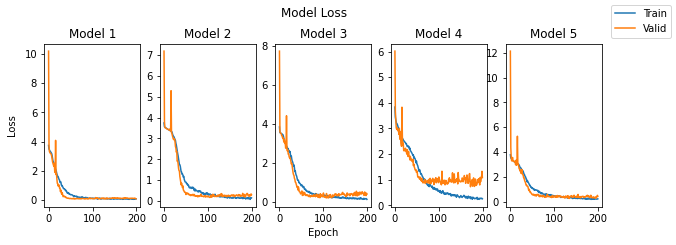

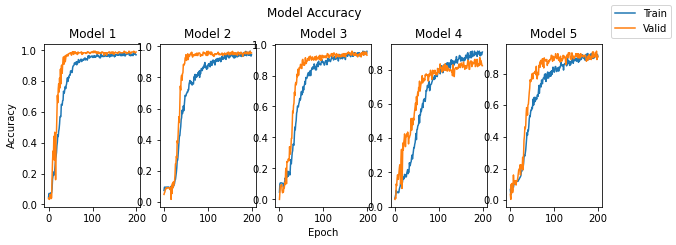

In [85]:
# Define a function to plot model history metric
def plot_model_history(history, metric = "Accuracy", plot_idx = [[0], [1]], row = True):
    if row == True:
        fig, axs = pyplot.subplots(1, len(plot_idx[0]))
        for plot_i in range(len(plot_idx[0])):
            axs[plot_i].plot(history.history[list(history.history.keys())[plot_idx[0][plot_i]]])
            axs[plot_i].plot(history.history[list(history.history.keys())[plot_idx[1][plot_i]]])
            axs[plot_i].set_title("Model " + str(plot_i + 1))
        fig.suptitle("Model " + metric, y = 1.05)
        pyplot.figlegend(["Train", "Valid"], loc = "upper right")
        # add a big axis, hide frame
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        pyplot.xlabel("Epoch")
        pyplot.ylabel(metric)
    else:
        fig, axs = pyplot.subplots(len(plot_idx[0]), 1)
        for plot_i in range(len(plot_idx[0])):
            axs[plot_i].plot(history.history[list(history.history.keys())[plot_idx[0][plot_i]]])
            axs[plot_i].plot(history.history[list(history.history.keys())[plot_idx[1][plot_i]]])
            axs[plot_i].set_title("Model " + str(plot_i + 1))
        fig.suptitle("Model " + metric, y = 1.05)
        pyplot.figlegend(["Train", "Valid"], loc = "upper right")
        # add a big axis, hide frame
        fig.add_subplot(111, frameon=False)
        # hide tick and tick label of the big axis
        pyplot.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        pyplot.xlabel("Epoch")
        pyplot.ylabel(metric)

pyplot.rcParams['figure.figsize'] = [10, 3]
# summarize history for accuracy
plot_model_history(model_history,
                   metric = "Loss",
                   plot_idx = [list(range(1, 1 + digit)), list(range(2 + 2 * digit, 2 + 3 * digit))],
                   row = True)
# summarize history for loss
plot_model_history(model_history,
                   metric = "Accuracy",
                   plot_idx = [list(range(1 + digit, 1 + 2 * digit)), list(range(2 + 3 * digit, 2 + 4 * digit))],
                   row = True)

### Model testing

We tested the final CNN model with the remaining {{n_test}} images.

In [135]:
test_idx = np.setdiff1d(range(img_filenames_count), train_idx)

# Define a function to convert categorical matrix list to character vector
def matrices2labels(matrices, class_level):
    label_idxes = np.array([np.apply_along_axis(lambda x: list(x).index(max(x)), 1, matrix) for matrix in matrices])
    label_vec = np.apply_along_axis(lambda x: np.array(class_level)[x.astype(int)], 1, label_idxes)
    label_str = np.apply_along_axis(lambda x: "".join(x), 0, label_vec)
    return label_str

# Derive predictions and convert them to labels
model_pred = matrices2labels(model.predict(data_x[test_idx]), class_level)
model_accuracy = np.mean(list(map(lambda x, y: x == y, model_pred, np.array(data_y_labels)[test_idx])))
model_accuracy_perc = str(model_accuracy * 100) + "%"

The final CNN model achieved an overall accuracy of {{model_accuracy_perc}}.